<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Систем сбора и обработки данных </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №3</font></center>
<center><font size="3">по дисциплине: «Машинное обучение» </font></center>
<br>

Выполнил:
- _ _ _ Дмитриченко Д.А. _ _ _

Проверила: _ _ _ Павлова А. И. _ _ _

<center>  Новосибирск, 2025  </center>

#Задание 1. Решите задачу классификации ансамблевыми алгоритмами бустинга, бэгинга. Напишите комментарии к программному коду.  

-- Если сможете для выполнения заданий используйте свои данные для обучения, если не получится используйте учебные

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import (
    BaggingClassifier, 
    ExtraTreesClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier, 
    RandomForestClassifier, 
    StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [49]:
import time # Импорт модуля time для работы с функциями времени


## Загрузка и предобработка данных
 Читаем файл из текущей директории

In [6]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [50]:
# Проверка типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [51]:
# Проверка пропусков
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [52]:
# Названия столбцов
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [54]:
# ============================
#   Диагностика нулевых значений
# Некоторые признаки содержат нули, хотя это невозможные значения
# (например, давление = 0). Их нужно заменить медианой.
# ============================
feature_columns = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

for column in feature_columns:
    print("============================================")
    print(f"{column} ==> Missing zeros : {len(df.loc[df[column] == 0])}")

Pregnancies ==> Missing zeros : 0
Glucose ==> Missing zeros : 0
BloodPressure ==> Missing zeros : 0
SkinThickness ==> Missing zeros : 0
Insulin ==> Missing zeros : 0
BMI ==> Missing zeros : 0
DiabetesPedigreeFunction ==> Missing zeros : 0
Age ==> Missing zeros : 0


**Заменяем нули на средние значения (Imputation)**

SimpleImputer производит замену значений на среднее по каждому столбцу.

In [57]:
fill_values = SimpleImputer(missing_values=0, strategy="mean", copy=False)
df[feature_columns] = fill_values.fit_transform(df[feature_columns])

# Проверка после заполнения
for column in feature_columns:
    print("============================================")
    print(f"{column} ==> Missing zeros : {len(df.loc[df[column] == 0])}")

Pregnancies ==> Missing zeros : 0
Glucose ==> Missing zeros : 0
BloodPressure ==> Missing zeros : 0
SkinThickness ==> Missing zeros : 0
Insulin ==> Missing zeros : 0
BMI ==> Missing zeros : 0
DiabetesPedigreeFunction ==> Missing zeros : 0
Age ==> Missing zeros : 0


## Разделение на обучающую и тестовую выборки

X — все столбцы, кроме Outcome
y — столбец Outcome (0/1)

In [58]:
X = df[feature_columns]
y = df.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Функция для оценки моделей

Функция `evaluate` возвращает комплексный набор метрик, необходимый для всестороннего анализа эффективности классификатора:

1.  **Accuracy (Общая точность)**
    *   **Определение:** Отношение числа верно классифицированных объектов к общему объему выборки.
    *   **Интерпретация:** Служит индикатором общей работоспособности модели. Однако, метрика не является репрезентативной в условиях дисбаланса классов, так как не учитывает распределение ошибок между классами.

2.  **Confusion Matrix (Матрица ошибок/сопряженности)**
    *   **Определение:** Таблица, визуализирующая расхождение между предсказанными и истинными метками классов.
    *   **Компоненты:**
        *   *True Positive (TP) / True Negative (TN):* Верно классифицированные положительные и отрицательные примеры.
        *   *False Positive (FP):* Ошибки I рода (ложное срабатывание).
        *   *False Negative (FN):* Ошибки II рода (пропуск события).
    *   **Назначение:** Позволяет диагностировать склонность модели к определенному типу ошибок.

3.  **Classification Report (Отчет о классификации)**
    *   **Определение:** Сводная таблица детальных метрик для каждого класса.
    *   **Ключевые показатели:**
        *   **Precision (Точность):** Доля истинно положительных срабатываний среди всех объектов, отнесенных моделью к положительному классу ($TP / (TP + FP)$). Характеризует способность модели не присваивать метку класса объектам другого класса.
        *   **Recall (Полнота):** Доля верно найденных положительных объектов среди всех объектов этого класса ($TP / (TP + FN)$). Характеризует способность модели обнаруживать искомый класс.
        *   **F1-score:** Гармоническое среднее между Precision и Recall. Является интегральной метрикой, позволяющей оценить баланс между точностью и полнотой.

In [61]:
# ============================
#   Функция для оценки моделей
# Возвращает accuracy, confusion matrix, classification report
# ============================
def evaluate(model, X_train, X_test, y_train, y_test):
    # Предсказания на обучении
    y_test_pred = model.predict(X_test)
    # Предсказания на тесте
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Задание 1. Бэгинг (Bagging) + Бустинг (Boosting)

**Bagging** (от англ. *Bootstrap Aggregating*) — метод построения ансамблей, направленный на снижение дисперсии (variance) алгоритмов машинного обучения.

**Алгоритмическая структура:**

1.  **Бутстрэп-выборка (Bootstrap Sampling):**
    *   Из исходного обучающего множества $X$ генерируется $N$ подвыборок одинакового размера.
    *   Формирование подвыборок происходит методом **случайного выбора с возвращением** (sampling with replacement), что обеспечивает статистическую независимость наборов данных.

2.  **Параллельное обучение (Parallel Training):**
    *   На каждой подвыборке независимо обучается базовый алгоритм (estimator). Как правило, используются модели с низкой смещенностью и высокой дисперсией (например, глубокие деревья решений).

3.  **Агрегирование (Aggregation):**
    *   Предсказания базовых моделей объединяются для получения финального результата.
    *   *В задачах классификации:* Применяется метод мажоритарного голосования (Majority Voting).
    *   *В задачах регрессии:* Применяется усреднение прогнозов.

**Теоретическое обоснование:**
Основной эффект метода заключается в уменьшении разброса ошибки ансамбля. Усреднение ответов некоррелированных (или слабо коррелированных) моделей позволяет нивелировать индивидуальные ошибки переобучения базовых алгоритмов, повышая обобщающую способность (generalization capability).

## Bagging Classifier (Бэггинг)

**Гиперпараметры sklearn.ensemble.BaggingClassifier**

Класс реализует алгоритм бэггинга в библиотеке `scikit-learn`. Ниже приведено описание ключевых параметров конфигурации:

*   **`estimator`** (по умолчанию `None`):
    *   Базовый алгоритм, на основе которого строится ансамбль. При значении `None` используется нередуцированное дерево решений (`DecisionTreeClassifier`).

*   **`n_estimators`** (`int`, по умолчанию `10`):
    *   Количество базовых моделей в ансамбле. Увеличение этого параметра снижает дисперсию ошибки до определенного предела, однако линейно увеличивает вычислительную сложность.

*   **`max_samples`** (`int` или `float`, по умолчанию `1.0`):
    *   Объем подвыборки для обучения каждого базового алгоритма. Может быть задан как абсолютное число (`int`) или как доля от исходной выборки (`float`).

*   **`max_features`** (`int` или `float`, по умолчанию `1.0`):
    *   Количество признаков, выбираемых случайным образом для обучения каждого базового алгоритма. Используется для декорреляции моделей (метод случайных подпространств).

*   **`bootstrap`** (`bool`, по умолчанию `True`):
    *   Определяет стратегию семплирования объектов. `True` — выборка с возвращением (классический Bagging), `False` — выборка без возвращения (Pasting).

*   **`bootstrap_features`** (`bool`, по умолчанию `False`):
    *   Определяет стратегию семплирования признаков (с возвращением или без).

*   **`oob_score`** (`bool`, по умолчанию `False`):
    *   Включает использование Out-of-Bag (OOB) оценки. Позволяет оценить качество модели на примерах, не попавших в бутстрэп-выборку, что является аналогом кросс-валидации.

*   **`random_state`** (`int` или `None`):
    *   Инициализатор генератора псевдослучайных чисел. Фиксация значения обеспечивает воспроизводимость экспериментов.

In [ ]:
# Бэгинг на базе деревьев решений
base_clf = DecisionTreeClassifier()
# Создаем ансамбль из 10 деревьев
model = BaggingClassifier(estimator=base_clf, n_estimators=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7532467532467533


In [ ]:
tree = DecisionTreeClassifier()
# Создаем ансамбль из 1500 деревьев
bagging_clf = BaggingClassifier(estimator=tree, n_estimators=1500, random_state=42)
bagging_clf.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_estimators,1500
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [25]:
evaluate(bagging_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[349   0]
 [  0 188]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    349.0  188.0       1.0      537.0         537.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[119  32]
 [ 24  56]]
ACCURACY SCORE:
0.7576
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.832168   0.636364  0.757576    0.734266      0.764357
recall       0.788079   0.700000  0.757576    0.744040      0.757576
f1-score     0.809524   0.666667  0.757576    0.738095      0.760049
support    151.000000  80.000000  0.757576  231.000000    231.000000


### Словарь для сохранения результатов

In [ ]:
scores = {
    'Bagging Classifier 1500': {
        'Train': accuracy_score(y_train, bagging_clf.predict(X_train)),
        'Test': accuracy_score(y_test, bagging_clf.predict(X_test)),
    },
}

In [19]:
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.7575757575757576}}

## ExtraTreesClassifier — Extremely Randomized Trees

`ExtraTreesClassifier` — ансамбль "экстремально рандомизированных деревьев".

**Основные отличия от Random Forest**

1. **Максимальная рандомизация при разбиениях**
   - В RandomForest подбирается лучший признак и порог разбиения.
   - В ExtraTrees порог выбирается СЛУЧАЙНО, а не оптимально.

2. **Больше деревьев → меньше переобучение**
   - Экстремальная случайность делает отдельные деревья очень "слабыми",
     но их ансамбль работает стабильно и точно.

**Преимущества**

* Быстрее RandomForest

* Более низкое переобучение

* Высокая точность

* Хорошо работает "из коробки"

**Недостатки**

* Из-за сильной рандомизации иногда может проигрывать RF на гладких задачах

In [ ]:
ex_tree_clf = ExtraTreesClassifier(n_estimators=1000, max_features=7, random_state=42)
ex_tree_clf.fit(X_train, y_train)
evaluate(ex_tree_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[349   0]
 [  0 188]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    349.0  188.0       1.0      537.0         537.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[124  27]
 [ 25  55]]
ACCURACY SCORE:
0.7749
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.832215   0.670732  0.774892    0.751473      0.776290
recall       0.821192   0.687500  0.774892    0.754346      0.774892
f1-score     0.826667   0.679012  0.774892    0.752840      0.775531
support    151.000000  80.000000  0.774892  231.000000    231.000000


In [21]:
scores['Extra Tree'] = {
        'Train': accuracy_score(y_train, ex_tree_clf.predict(X_train)),
        'Test': accuracy_score(y_test, ex_tree_clf.predict(X_test)),
    }
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.7575757575757576},
 'Extra Tree': {'Train': 1.0, 'Test': 0.7748917748917749}}

## AdaBoost (Адаптивный Бустинг)
Последовательно обучает слабые модели, увеличивая вес неправильно классифицированных примеров

**Boosting** — семейство алгоритмов построения композиции моделей путем последовательного обучения. Метод основан на гипотезе, что объединение множества "слабых" алгоритмов (weak learners) позволяет построить "сильный" классификатор с высокой предсказательной способностью.

**Ключевые принципы:**

1.  **Последовательная оптимизация:**
    *   Модели ансамбля $(b_1, b_2, ..., b_N)$ обучаются итеративно.
    *   Каждая модель $b_k$ обучается с целью минимизации функции потерь композиции из предыдущих моделей $b_{1...k-1}$.

2.  **Адаптивное взвешивание:**
    *   В классических реализациях (например, AdaBoost) алгоритм повышает веса объектов обучающей выборки, на которых предыдущие модели допустили ошибку. Это заставляет последующие модели фокусироваться на "сложных" примерах.
    *   В градиентном бустинге новая модель обучается предсказывать антиградиент функции потерь (остатки) предыдущего шага.

3.  **Результативность:**
    *   Бустинг позволяет существенно снизить как смещение (bias), так и дисперсию (variance) модели.
    *   Является одним из наиболее эффективных подходов для работы с табличными данными, часто превосходя нейросетевые подходы.

4.  **Ограничения:**
    *   Высокая чувствительность к шуму в данных и выбросам из-за стремления минимизировать ошибки на всех объектах.
    *   Склонность к переобучению при избыточной сложности базовых моделей или слишком большом их количестве.

In [67]:
ada_boost_clf = AdaBoostClassifier(n_estimators=30)
ada_boost_clf.fit(X_train, y_train)
evaluate(ada_boost_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[316  33]
 [ 85 103]]
ACCURACY SCORE:
0.7803
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.788030    0.757353  0.780261    0.772691      0.777290
recall       0.905444    0.547872  0.780261    0.726658      0.780261
f1-score     0.842667    0.635802  0.780261    0.739235      0.770245
support    349.000000  188.000000  0.780261  537.000000    537.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[131  20]
 [ 34  46]]
ACCURACY SCORE:
0.7662
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.793939   0.696970  0.766234    0.745455      0.760357
recall       0.867550   0.575000  0.766234    0.721275      0.766234
f1-score     0.829114   0.630137  0.766234    0.729625      0.760204
support    151.000000  80.000000  0.766234  231.000000    231.000000


In [28]:
scores['AdaBoost'] = {
        'Train': accuracy_score(y_train, ada_boost_clf.predict(X_train)),
        'Test': accuracy_score(y_test, ada_boost_clf.predict(X_test)),
    }
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.7575757575757576},
 'Extra Tree': {'Train': 1.0, 'Test': 0.7748917748917749},
 'AdaBoost': {'Train': 0.7802607076350093, 'Test': 0.7662337662337663}}

## Stochastic Gradient Boosting

**Gradient Boosting** реализует подход бустинга как задачу численной оптимизации в функциональном пространстве. Целью является минимизация дифференцируемой функции потерь $L(y, F(x))$ путем итеративного добавления базовых алгоритмов (деревьев), аппроксимирующих отрицательный градиент этой функции.

**Спецификация параметров sklearn:**

*   **`loss`** (по умолчанию `'log_loss'`): Оптимизируемая функция потерь. Для задач классификации используется логистическая функция потерь (log-likelihood).
*   **`learning_rate`** (`float`, по умолчанию `0.1`):
    *   Коэффициент сжатия (shrinkage). Масштабирует вклад каждого нового дерева в итоговую композицию. Низкие значения требуют большего числа итераций (`n_estimators`), но повышают обобщающую способность (регуляризация).
*   **`n_estimators`** (`int`, по умолчанию `100`): Количество итераций бустинга (число деревьев).
*   **`subsample`** (`float`, по умолчанию `1.0`):
    *   Доля обучающей выборки, используемая для построения каждого дерева. Значения $< 1.0$ переводят алгоритм в режим **Стохастического градиентного бустинга**, что снижает дисперсию.
*   **`criterion`** (`'friedman_mse'`): Критерий оценки качества разбиения узла, адаптированный для бустинга.
*   **`max_depth`** (`int`, по умолчанию `3`):
    *   Ограничение максимальной глубины дерева. В бустинге используются "слабые" модели (неглубокие деревья) для предотвращения переобучения. Глубина определяет порядок взаимодействий признаков, учитываемых моделью.
*   **`min_samples_split` / `min_samples_leaf`**: Параметры пред-обрезки (pre-pruning) деревьев, ограничивающие минимальное количество объектов для деления узла или формирования листа.
*   **`validation_fraction`**: Доля данных, выделяемая для ранней остановки (Early Stopping) с целью предотвращения переобучения.

> **Важно:** Параметры `learning_rate` и `n_estimators` являются взаимосвязанными: уменьшение темпа обучения требует пропорционального увеличения количества эстиматоров.

In [ ]:
grad_boost_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
grad_boost_clf.fit(X_train, y_train)
evaluate(grad_boost_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[342   7]
 [ 19 169]]
ACCURACY SCORE:
0.9516
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.947368    0.960227  0.951583    0.953798      0.951870
recall       0.979943    0.898936  0.951583    0.939439      0.951583
f1-score     0.963380    0.928571  0.951583    0.945976      0.951194
support    349.000000  188.000000  0.951583  537.000000    537.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[116  35]
 [ 26  54]]
ACCURACY SCORE:
0.7359
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.816901   0.606742  0.735931    0.711821      0.744119
recall       0.768212   0.675000  0.735931    0.721606      0.735931
f1-score     0.791809   0.639053  0.735931    0.715431      0.738906
support    151.000000  80.000000  0.735931  231.000000    231.000000


In [30]:
scores['Gradient Boosting'] = {
        'Train': accuracy_score(y_train, grad_boost_clf.predict(X_train)),
        'Test': accuracy_score(y_test, grad_boost_clf.predict(X_test)),
    }
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.7575757575757576},
 'Extra Tree': {'Train': 1.0, 'Test': 0.7748917748917749},
 'AdaBoost': {'Train': 0.7802607076350093, 'Test': 0.7662337662337663},
 'Gradient Boosting': {'Train': 0.9515828677839852,
  'Test': 0.7359307359307359}}

## Voting Ensemble

**Принцип действия `VotingClassifier`:**

1. **Гетерогенность базовых алгоритмов:**

    - Используются модели с различными индуктивными смещениями (inductive bias).
    - Разнообразие подходов обеспечивает декорреляцию ошибок: сложные паттерны, пропущенные одной моделью, могут быть выявлены другой.
2. **Механизм агрегации (Voting Strategy):**

    - В представленном коде используется стратегия **Hard Voting** (Жесткое голосование).
    - Итоговый класс определяется как мода (наиболее часто встречающееся значение) предсказаний базовых классификаторов: <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mover accent="true"><mi>y</mi><mo>^</mo></mover><mo>=</mo><mtext>mode</mtext><mo stretchy="false">(</mo><msub><mi>C</mi><mn>1</mn></msub><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo separator="true">,</mo><msub><mi>C</mi><mn>2</mn></msub><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo separator="true">,</mo><mi mathvariant="normal">.</mi><mi mathvariant="normal">.</mi><mi mathvariant="normal">.</mi><mo separator="true">,</mo><msub><mi>C</mi><mi>n</mi></msub><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo stretchy="false">)</mo></mrow></semantics></math>
3. **Обучение:**

    - Метод `fit` инициирует независимое обучение каждой модели из списка `estimators` на полной обучающей выборке.

**Цель:** Повышение робастности системы и достижение метрик, превосходящих показатели лучшего одиночного алгоритма в ансамбле.

**Логика работы**

1. **Logistic Regression**  
Линейная модель, хорошо работает на простых данных.
2. **Decision Tree**  
Может моделировать нелинейные зависимости.
3. **SVM**  
Максимизирует разделяющую гиперплоскость.

* * *

**Типы голосования:**

- **hard voting**  
Класс выбирается большинством голосов предсказаний моделей.
- **soft voting**  
Учитываются вероятности классов (если модели их возвращают).  
Более точный, но требует моделей с `predict_proba`.

* * *

**Плюсы**

- Простота
- Улучшение устойчивости
- Объединение сильных сторон разных моделей

**Минусы**

- Не такие точные, как бустинг или стекинг

In [ ]:
estimators = []
log_reg = LogisticRegression(solver='liblinear')
estimators.append(('Logistic', log_reg))

tree = DecisionTreeClassifier()
estimators.append(('Tree', tree))

svm_clf = SVC(gamma='scale')
estimators.append(('SVM', svm_clf))

voting = VotingClassifier(estimators=estimators)
voting.fit(X_train, y_train)

evaluate(voting, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[327  22]
 [ 82 106]]
ACCURACY SCORE:
0.8063
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.799511    0.828125  0.806331    0.813818      0.809529
recall       0.936963    0.563830  0.806331    0.750396      0.806331
f1-score     0.862797    0.670886  0.806331    0.766841      0.795610
support    349.000000  188.000000  0.806331  537.000000    537.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[130  21]
 [ 36  44]]
ACCURACY SCORE:
0.7532
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.783133   0.676923  0.753247    0.730028      0.746350
recall       0.860927   0.550000  0.753247    0.705464      0.753247
f1-score     0.820189   0.606897  0.753247    0.713543      0.746322
support    151.000000  80.000000  0.753247  231.000000    231.000000


In [32]:
scores['Voting'] = {
        'Train': accuracy_score(y_train, voting.predict(X_train)),
        'Test': accuracy_score(y_test, voting.predict(X_test)),
    }
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.7575757575757576},
 'Extra Tree': {'Train': 1.0, 'Test': 0.7748917748917749},
 'AdaBoost': {'Train': 0.7802607076350093, 'Test': 0.7662337662337663},
 'Gradient Boosting': {'Train': 0.9515828677839852,
  'Test': 0.7359307359307359},
 'Voting': {'Train': 0.8063314711359404, 'Test': 0.7532467532467533}}

## Model Comparison

<Axes: >

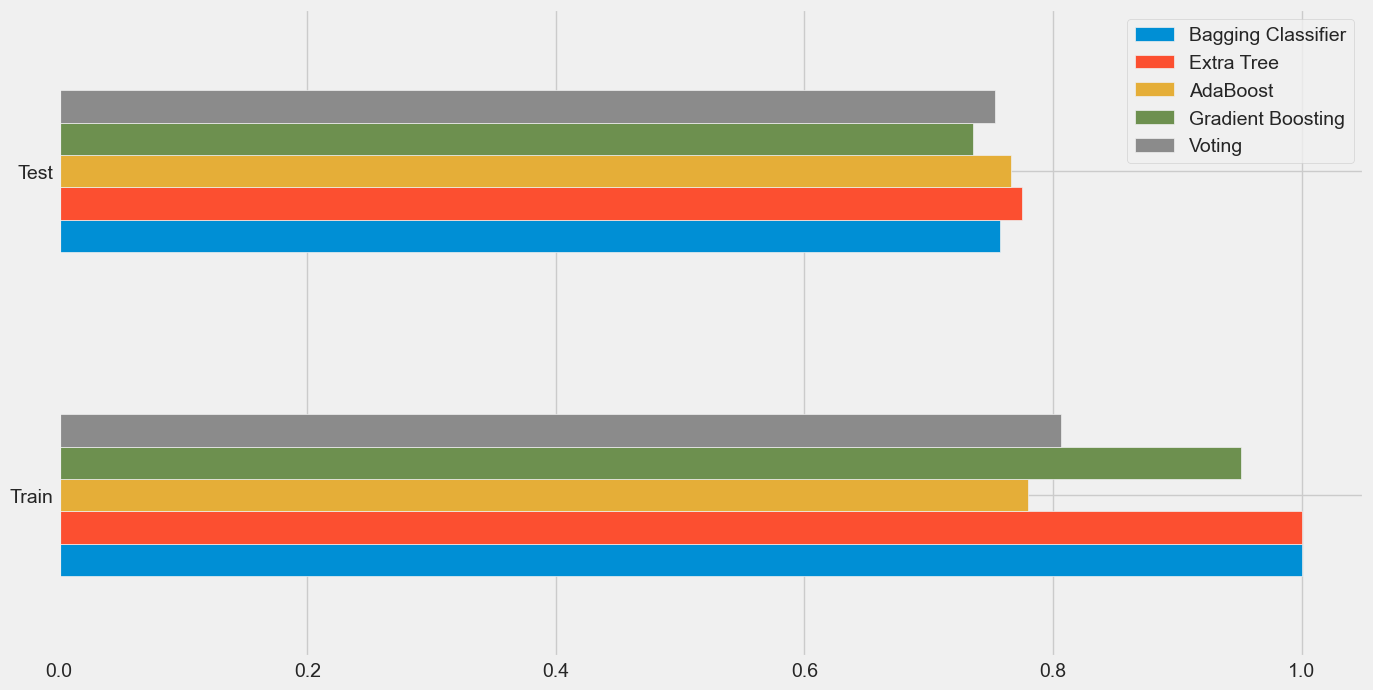

In [33]:
scores_df = pd.DataFrame(scores)

scores_df.plot(kind='barh', figsize=(15, 8))

In [118]:
scores_df

,Bagging Classifier,Extra Tree,AdaBoost,Gradient Boosting,Voting
Train,1.000000,1.000000,0.780261,0.951583,0.806331
Test,0.757576,0.774892,0.766234,0.735931,0.753247


# Задание 2. Стекинг (Stacking)

**Stacking** (Стекинг) — метод ансамблирования, реализующий иерархическую структуру обучения, где прогнозы базовых алгоритмов используются в качестве входных признаков для мета-алгоритма.

**Архитектура стекинга:**

1.  **Базовый уровень (Level-0):**
    *   Состоит из набора гетерогенных (разнородных) моделей (например, SVM, kNN, Random Forest).
    *   Модели обучаются на исходном наборе данных $X$.

2.  **Формирование мета-признаков:**
    *   Базовые модели генерируют прогнозы для обучающей выборки (обычно с использованием процедуры кросс-валидации, чтобы избежать утечки данных).
    *   Эти прогнозы формируют новый набор данных, где каждый столбец соответствует выходам конкретной базовой модели.

3.  **Мета-уровень (Level-1):**
    *   Обучается **мета-модель** (blender/meta-learner).
    *   Входом для мета-модели являются прогнозы моделей первого уровня, а целевой переменной — истинные метки $y$.
    *   Задача мета-модели — найти оптимальную (часто нелинейную) функцию комбинации ответов базовых алгоритмов.

**Преимущества и применение:**
*   **Синергия алгоритмов:** Стекинг позволяет эффективно комбинировать сильные стороны различных математических аппаратов.
*   **Максимизация точности:** Метод часто используется для достижения State-of-the-Art результатов в задачах, где критична каждая доля процента точности.
*   **Устойчивость:** При использовании простой модели на мета-уровне (например, логистической регрессии), ансамбль способен корректировать систематические ошибки базовых моделей без значительного риска переобучения.

In [68]:
# Read the training datasets
X_train_original = pd.read_csv('X_train_original.csv')
X_train_original = X_train_original.set_index('Unnamed: 0')

X_train_transformed = pd.read_csv('X_train_transformed.csv')
X_train_transformed = X_train_transformed.set_index('Unnamed: 0')

X_train_discretized = pd.read_csv('X_train_discretized.csv')
X_train_discretized = X_train_discretized.set_index('Unnamed: 0')

# Read the test datasets
X_test_original = pd.read_csv('X_test_original.csv')
X_test_original = X_test_original.set_index('Unnamed: 0')

X_test_transformed = pd.read_csv('X_test_transformed.csv')
X_test_transformed = X_test_transformed.set_index('Unnamed: 0')

X_test_discretized = pd.read_csv('X_test_discretized.csv')
X_test_discretized = X_test_discretized.set_index('Unnamed: 0')

# Read the target variable for training and testing
y_train = pd.read_csv('y_train.csv')
y_train = y_train.set_index('Unnamed: 0').squeeze()

y_test = pd.read_csv('y_test.csv')
y_test = y_test.set_index('Unnamed: 0').squeeze()

In [35]:
X_train_original

,age,ed,employ,address,debtinc,income_ratio,creddebt_ratio,othdebt_ratio
Unnamed: 0,,,,,,,,
286,-0.757182,-0.781351,0.421454,-0.214252,-0.625682,-3.943046e-01,-0.316469,-0.657086
146,-0.882261,2.385406,-1.105097,-0.785197,0.323823,-5.843492e-01,-0.679458,-0.030961
214,-0.131785,-0.781351,1.184729,-0.785197,0.027102,9.676817e-01,1.680901,0.306257
528,1.994565,0.274235,3.474556,0.784903,-0.358634,6.478975e+00,1.890876,4.123403
165,0.618692,0.274235,0.726764,0.356694,1.288163,1.822882e+00,3.180092,3.414949
...,...,...,...,...,...,...,...,...
144,0.743771,-0.781351,1.184729,1.213112,-0.714698,7.459630e-01,-0.632760,0.096423
645,-1.507658,0.274235,-1.257752,-1.070670,-0.937238,-7.756359e-02,-0.256113,-0.783204
72,1.494247,-0.781351,2.711280,1.784057,0.383167,1.759534e+00,2.095123,1.782697


In [97]:
scores_2 = {}

## LogisticRegression

In [74]:
logistic = LogisticRegression(penalty=None, C=1.0, fit_intercept=True, class_weight='balanced', l1_ratio=None)
logistic.fit(X_train_transformed, y_train)

y_pred_train = logistic.predict(X_train_transformed)
y_pred_test = logistic.predict(X_test_transformed)
y_prob_test = logistic.predict_proba (X_test_transformed)

evaluate(logistic, X_train_transformed, X_test_transformed, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[274  90]
 [ 25  96]]
ACCURACY SCORE:
0.7629
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.916388    0.516129  0.762887    0.716258      0.816530
recall       0.752747    0.793388  0.762887    0.773068      0.762887
f1-score     0.826546    0.625407  0.762887    0.725977      0.776365
support    364.000000  121.000000  0.762887  485.000000    485.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[119  34]
 [ 16  41]]
ACCURACY SCORE:
0.7619
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.881481   0.546667  0.761905    0.714074      0.790603
recall       0.777778   0.719298  0.761905    0.748538      0.761905
f1-score     0.826389   0.621212  0.761905    0.723801      0.770698
support    153.000000  57.000000  0.761905  210.000000    210.000000


In [98]:
scores_2['LogisticRegression'] = {
    'Train': accuracy_score(y_train, logistic.predict(X_train_transformed)),
    'Test': accuracy_score(y_test, logistic.predict(X_test_transformed)),
}

## BaggingClassifier

In [ ]:
bag_clf = BaggingClassifier(estimator=logistic, n_estimators=100, max_samples=1.0, max_features=1.0,
                            bootstrap=True, bootstrap_features=False, n_jobs=-1, random_state=111)

bag_clf.fit(X_train_transformed, y_train)

y_pred_train = bag_clf.predict(X_train_transformed)
y_pred_test = bag_clf.predict(X_test_transformed)
y_prob_test = bag_clf.predict_proba (X_test_transformed)

evaluate(bag_clf, X_train_transformed, X_test_transformed, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[276  88]
 [ 25  96]]
ACCURACY SCORE:
0.7670
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.916944    0.521739   0.76701    0.719341      0.818346
recall       0.758242    0.793388   0.76701    0.775815      0.767010
f1-score     0.830075    0.629508   0.76701    0.729792      0.780037
support    364.000000  121.000000   0.76701  485.000000    485.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[119  34]
 [ 16  41]]
ACCURACY SCORE:
0.7619
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.881481   0.546667  0.761905    0.714074      0.790603
recall       0.777778   0.719298  0.761905    0.748538      0.761905
f1-score     0.826389   0.621212  0.761905    0.723801      0.770698
support    153.000000  57.000000  0.761905  210.000000    210.000000


In [99]:
scores_2['Bagging Classifier 100'] = {
    'Train': accuracy_score(y_train, bag_clf.predict(X_train_transformed)),
    'Test': accuracy_score(y_test, bag_clf.predict(X_test_transformed)),
}

## RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=2,
                                min_samples_leaf=1, max_features='sqrt', bootstrap=True, n_jobs=-1,
                                random_state=111, class_weight='balanced', max_samples=None)

rf_clf.fit(X_train_transformed, y_train)

y_pred_train = rf_clf.predict(X_train_transformed)
y_pred_test = rf_clf.predict(X_test_transformed)
y_prob_test = rf_clf.predict_proba (X_test_transformed)

evaluate(rf_clf, X_train_transformed, X_test_transformed, y_train, y_test)

Evaluation the Model on Training Set
Confusion Matrix:
[[303  61]
 [ 17 104]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       364
           1       0.63      0.86      0.73       121

    accuracy                           0.84       485
   macro avg       0.79      0.85      0.81       485
weighted avg       0.87      0.84      0.85       485

--------------------------------------------------------------------------------
Evaluation the Model on Testing Set
Confusion Matrix:
[[121  32]
 [ 18  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       153
           1       0.55      0.68      0.61        57

    accuracy                           0.76       210
   macro avg       0.71      0.74      0.72       210
weighted avg       0.78      0.76      0.77       210



In [100]:
scores_2['RandomForestClassifier'] = {
    'Train': accuracy_score(y_train, rf_clf.predict(X_train_transformed)),
    'Test': accuracy_score(y_test, rf_clf.predict(X_test_transformed)),
}

## AdaBoostClassifier

In [78]:
adabo_clf = AdaBoostClassifier(estimator=logistic, n_estimators=10, learning_rate=0.01, algorithm='SAMME', random_state=111)
adabo_clf.fit(X_train_transformed, y_train)

y_pred_train = adabo_clf.predict(X_train_transformed)
y_pred_test = adabo_clf.predict(X_test_transformed)
y_prob_test = adabo_clf.predict_proba (X_test_transformed)

evaluate(adabo_clf, X_train_transformed, X_test_transformed, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[274  90]
 [ 25  96]]
ACCURACY SCORE:
0.7629
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.916388    0.516129  0.762887    0.716258      0.816530
recall       0.752747    0.793388  0.762887    0.773068      0.762887
f1-score     0.826546    0.625407  0.762887    0.725977      0.776365
support    364.000000  121.000000  0.762887  485.000000    485.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[119  34]
 [ 16  41]]
ACCURACY SCORE:
0.7619
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.881481   0.546667  0.761905    0.714074      0.790603
recall       0.777778   0.719298  0.761905    0.748538      0.761905
f1-score     0.826389   0.621212  0.761905    0.723801      0.770698
support    153.000000  57.000000  0.761905  210.000000    210.000000


f:\Users\ASUS\miniconda3\envs\pytorch-env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


In [101]:
scores_2['AdaBoostClassifier'] = {
    'Train': accuracy_score(y_train, adabo_clf.predict(X_train_transformed)),
    'Test': accuracy_score(y_test, adabo_clf.predict(X_test_transformed)),
}

<Axes: >

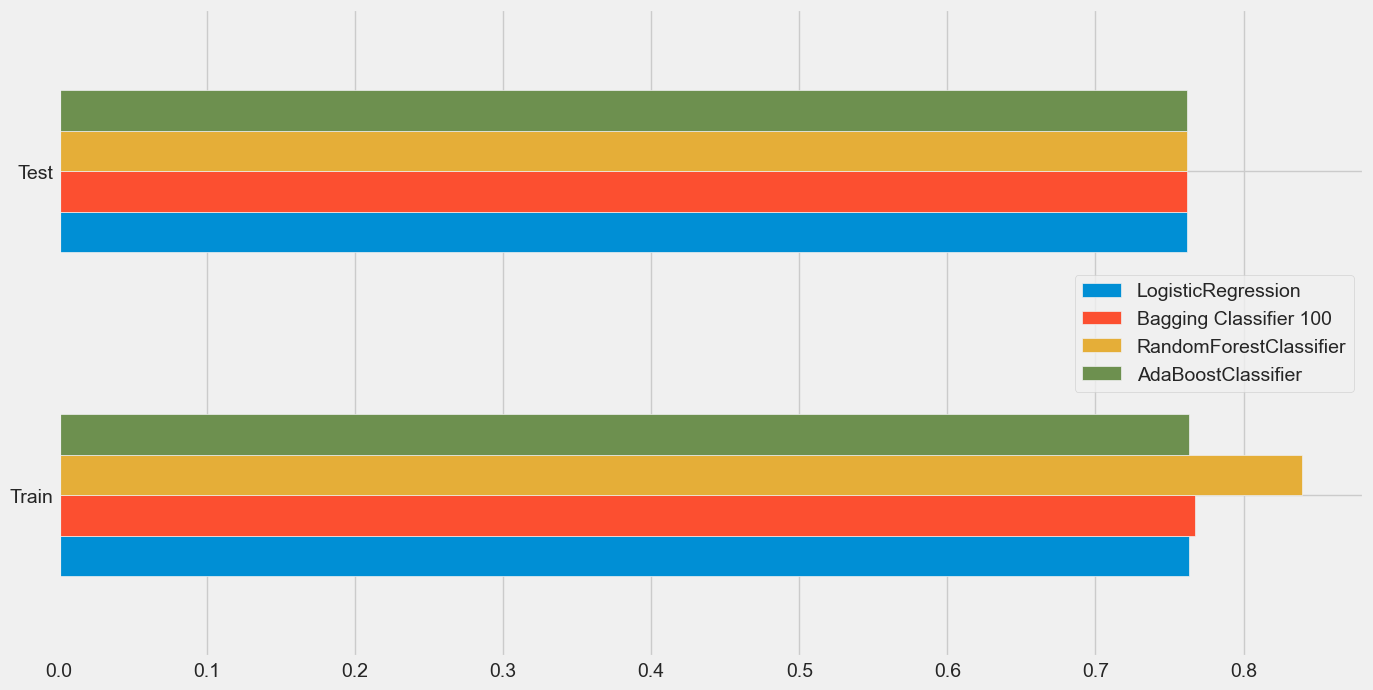

In [102]:
scores_df_2 = pd.DataFrame(scores_2)

scores_df_2.plot(kind='barh', figsize=(15, 8))

В данном разделе реализуется методология **Stacking (Стекинга)** — иерархического ансамблирования моделей. Эксперимент направлен на сравнение прогностической способности отдельных гетерогенных (разнородных) алгоритмов и их композиции.

**Методологические этапы:**

1. **Инициализация базовых эстиматоров (Level-0 Models):**

    - Выбраны алгоритмы различной математической природы для обеспечения декорреляции ошибок: метрические (деревья), линейные (лог. регрессия, SVM), вероятностные (Наивный Байес) и нейросетевые (MLP).
    - Для большинства моделей применяется параметр `class_weight="balanced"` для коррекции дисбаланса классов путем взвешивания функции потерь.
2. **Конфигурация мета-алгоритма (Level-1 Model):**

    - В качестве мета-классификатора (`final_estimator`) используется **Gaussian Naive Bayes**. Это нестандартный выбор (чаще используется логистическая регрессия), подразумевающий, что распределение мета-признаков подчиняется нормальному закону.
    - Активирован параметр `passthrough=True`. Это означает, что мета-модель обучается на расширенном пространстве признаков: исходные данные <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>X</mi></mrow></semantics></math>X конкатенируются с прогнозами базовых моделей. Это позволяет мета-алгоритму находить сложные зависимости, учитывая как контекст исходных данных, так и "мнения" экспертов (базовых моделей).
3. **Сравнительный анализ (ROC-AUC):**

    - Для объективной оценки производится независимое обучение каждого базового алгоритма.
    - Строятся кривые ошибок (ROC curves) и вычисляется площадь под кривой (AUC).
    - Особое внимание уделяется методу опорных векторов (Linear SVM), который не возвращает вероятности по умолчанию, требуя использования функции решающего правила (`decision_function`).

## КОНФИГУРАЦИЯ БАЗОВЫХ АЛГОРИТМОВ (Level-0 Estimators)

In [108]:
# Дерево решений: Ограничена глубина (max_depth=2) для предотвращения переобучения
# class_weight="balanced" автоматически корректирует веса классов обратно пропорционально их частоте.
tree = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=10,
                            min_samples_leaf=5, random_state=111, class_weight="balanced")

In [110]:
# Логистическая регрессия: Линейный классификатор без регуляризации (penalty=None).
logistic = LogisticRegression(penalty=None, C=1.0, fit_intercept=True, class_weight='balanced', l1_ratio=None)

In [111]:
# Линейный SVM: Метод опорных векторов с L1-регуляризацией (разреживание признаков).
# Используется loss='squared_hinge' для дифференцируемости. multi_class='ovr' (One-vs-Rest) для многоклассовости.
lsvm = LinearSVC(penalty='l1', loss='squared_hinge', C=0.5, multi_class='ovr',
                fit_intercept=True, class_weight='balanced', dual=False, random_state=111, max_iter=1000000)

In [112]:
# Гауссовский Наивный Байес: Вероятностный классификатор, предполагающий нормальное распределение признаков.
nb = GaussianNB(priors=None)

In [113]:
# Многослойный перцептрон (Нейросеть): Архитектура с двумя скрытыми слоями (20 и 10 нейронов).
# Функция активации 'tanh', оптимизатор 'adam'.
ann = MLPClassifier(hidden_layer_sizes=(20, 10), activation='tanh', solver='adam', alpha=0, batch_size=20,
                learning_rate='constant', learning_rate_init=0.01, max_iter=100000, random_state=111, n_iter_no_change=20)

## ИНИЦИАЛИЗАЦИЯ И ОБУЧЕНИЕ АНСАМБЛЯ (STACKING)

In [116]:
# Инициализация стекинга.
# estimators: список кортежей (имя, модель).
# final_estimator: мета-модель (в данном случае NB), агрегирующая предсказания.
# passthrough=True: критически важно — мета-модель получает на вход (X_исходные + Предсказания_базовых).
stack_clf = StackingClassifier([("tree",tree), ("logistic",logistic), ("lsvm",lsvm), ("nb",nb)],
                            final_estimator=nb, cv=5, stack_method='auto', n_jobs=-1, passthrough=True, verbose=0)

# Обучение модели ансамбля
stack_clf.fit(X_train_transformed, y_train)

# Make predictions
y_pred_train = stack_clf.predict(X_train_transformed)
y_pred_test = stack_clf.predict(X_test_transformed)
#y_prob_test = stack_clf.predict_proba(X_test_discretized)

evaluate(stack_clf, X_train_transformed, X_test_transformed, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[286  78]
 [ 32  89]]
ACCURACY SCORE:
0.7732
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.899371    0.532934  0.773196    0.716153      0.807951
recall       0.785714    0.735537  0.773196    0.760626      0.773196
f1-score     0.838710    0.618056  0.773196    0.728383      0.783660
support    364.000000  121.000000  0.773196  485.000000    485.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[125  28]
 [ 17  40]]
ACCURACY SCORE:
0.7857
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.880282   0.588235  0.785714    0.734258      0.801012
recall       0.816993   0.701754  0.785714    0.759374      0.785714
f1-score     0.847458   0.640000  0.785714    0.743729      0.791148
support    153.000000  57.000000  0.785714  210.000000    210.000000


In [106]:
stack_clf

,estimators,"[('tree', ...), ('logistic', ...), ...]"
,final_estimator,GaussianNB()
,cv,5
,stack_method,'auto'
,n_jobs,-1
,passthrough,True
,verbose,0
,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,10


## СРАВНИТЕЛЬНЫЙ АНАЛИЗ (ИНДИВИДУАЛЬНЫЕ МОДЕЛИ VS АНСАМБЛЬ)

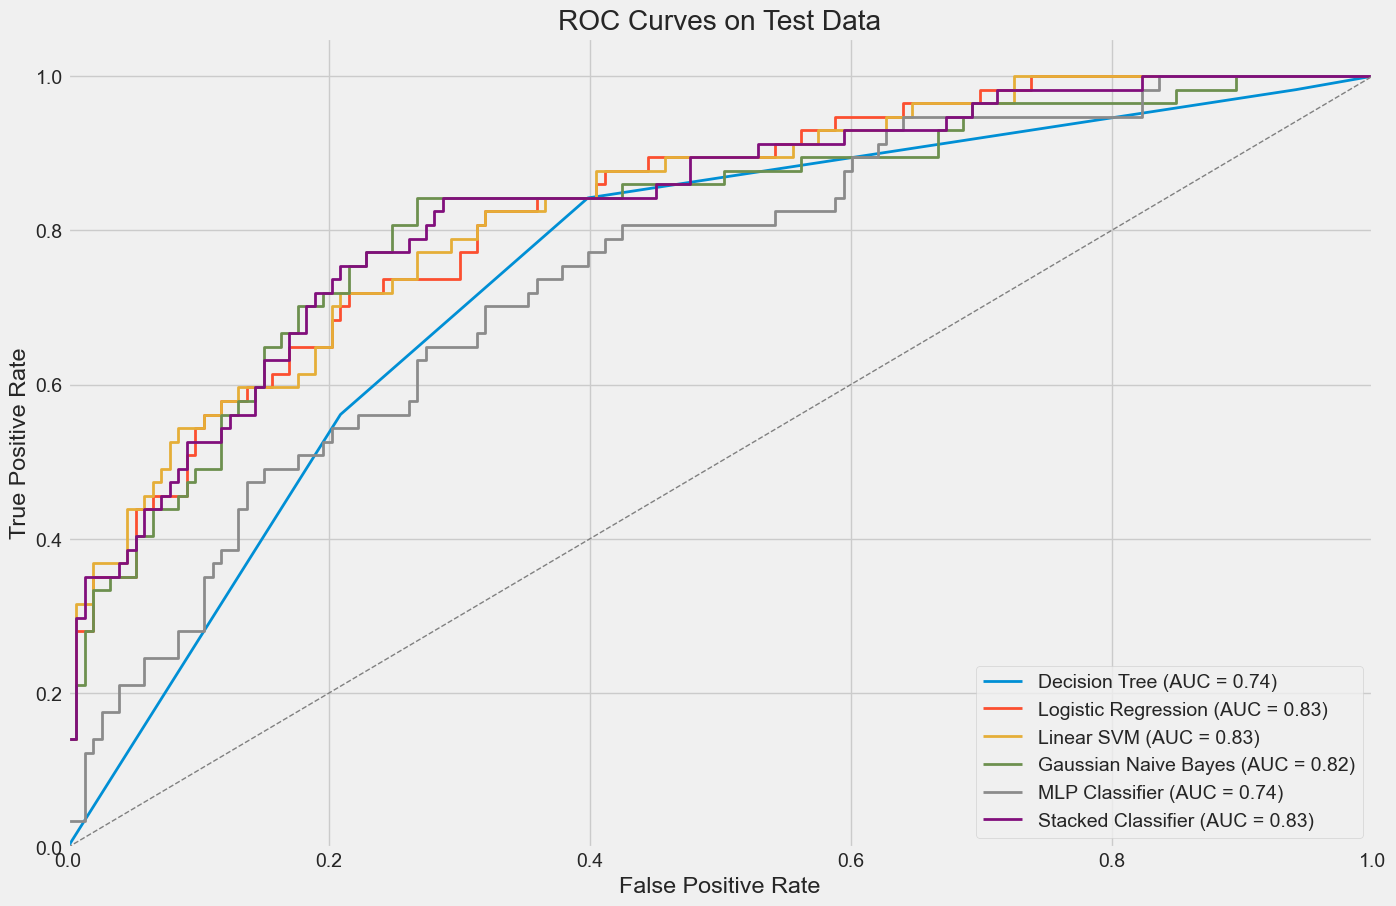

In [120]:
# Повторное определение классификаторов для их независимого обучения и сравнения
# (Параметры идентичны описанным выше)
tree = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=10,
                            min_samples_leaf=5, random_state=111, class_weight="balanced")
logistic = LogisticRegression(penalty=None, C=1.0, fit_intercept=True, class_weight='balanced', l1_ratio=None)
lsvm = LinearSVC(penalty='l1', loss='squared_hinge', C=0.5, multi_class='ovr',
                fit_intercept=True, class_weight='balanced', dual=False, random_state=111, max_iter=1000000)
nb = GaussianNB(priors=None)
ann = MLPClassifier(hidden_layer_sizes=(20, 10), activation='tanh', solver='adam', alpha=0, batch_size=20,
                    learning_rate='constant', learning_rate_init=0.01, max_iter=100000, random_state=111, n_iter_no_change=20)

# Независимое обучение каждой модели
tree.fit(X_train_transformed, y_train)
logistic.fit(X_train_transformed, y_train)
lsvm.fit(X_train_transformed, y_train)
nb.fit(X_train_transformed, y_train)
ann.fit(X_train_transformed, y_train)

# Создание экземпляра StackingClassifier
stack_clf = StackingClassifier(estimators=[("tree", tree), ("logistic", logistic),
                                        ("lsvm", lsvm), ("nb", nb)],
                            final_estimator=nb, cv=5, stack_method='auto', n_jobs=-1, passthrough=True, verbose=0)

# Обучение стекинг-классификатора
stack_clf.fit(X_train_transformed, y_train)

# Словарь классификаторов для итерации при построении графиков
classifiers = {
    "Decision Tree": tree,
    "Logistic Regression": logistic,
    "Linear SVM": lsvm,
    "Gaussian Naive Bayes": nb,
    "MLP Classifier": ann,
    "Stacked Classifier": stack_clf
}

# Инициализация словарей для хранения метрик ROC-кривой (FPR, TPR) и площади AUC
fpr = {}
tpr = {}
roc_auc = {}

# Вычисление ROC-кривых и площади ROC AUC для каждого классификатора
for name, clf in classifiers.items():
    # Linear SVM не поддерживает predict_proba по умолчанию, используем decision_function
    # (расстояние до разделяющей гиперплоскости)
    if name == "Linear SVM":
        y_pred_decision = clf.decision_function(X_test_transformed)
        fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_decision)
    # Для стекинга и остальных моделей берем вероятность положительного класса (индекс 1)
    elif name == "Stacked Classifier":
        y_pred_proba = stack_clf.predict_proba(X_test_transformed)[:, 1]
        fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_proba)
    else:
        y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]
        fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_proba)

    roc_auc[name] = roc_auc_score(y_test, y_pred_proba)

# Визуализация
plt.figure(figsize=(15, 10))
for name in classifiers:
    plt.plot(fpr[name], tpr[name], lw=2, label=f'{name} (AUC = {roc_auc[name]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Test Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()